# U-Netを用いたマルチクラスセグメンテーションの実装

## ライブラリのインポート

In [1]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A

import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

2023-07-15 21:19:29.085946: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 21:19:29.192636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 21:19:29.706295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## データセットの定義

In [2]:
class CustomDataset(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/images_png' for i in img_dir]
        seg_paths = [i+'/masks_png' for i in img_dir]
        self.images,self.masks = [],[]
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):

        """__getitem__
        
        Returns the original image and transformed image and mask

        """
        img = np.array(Image.open(self.images[index]))
        orig_data = img.copy()

        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']

        return orig_data,img,mask



In [3]:
traindata_dir = ['Train/Rural/','Train/Urban/']
valdata_dir = ['Val/Rural/','Val/Urban/']

## Transformerの定義

- 256平方にリサイズ
- 標準化

In [4]:
t1 = A.Compose([
    A.Resize(256,256),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [5]:
train_dataset = CustomDataset(traindata_dir,transform = t1)
test_dataset = CustomDataset(valdata_dir,transform = t1)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

## データセットのチェック

3毎画像を取り出してそれぞれチェック

- 画像
- 正規化後の画像
- 答え(セグメンテーションの答え)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


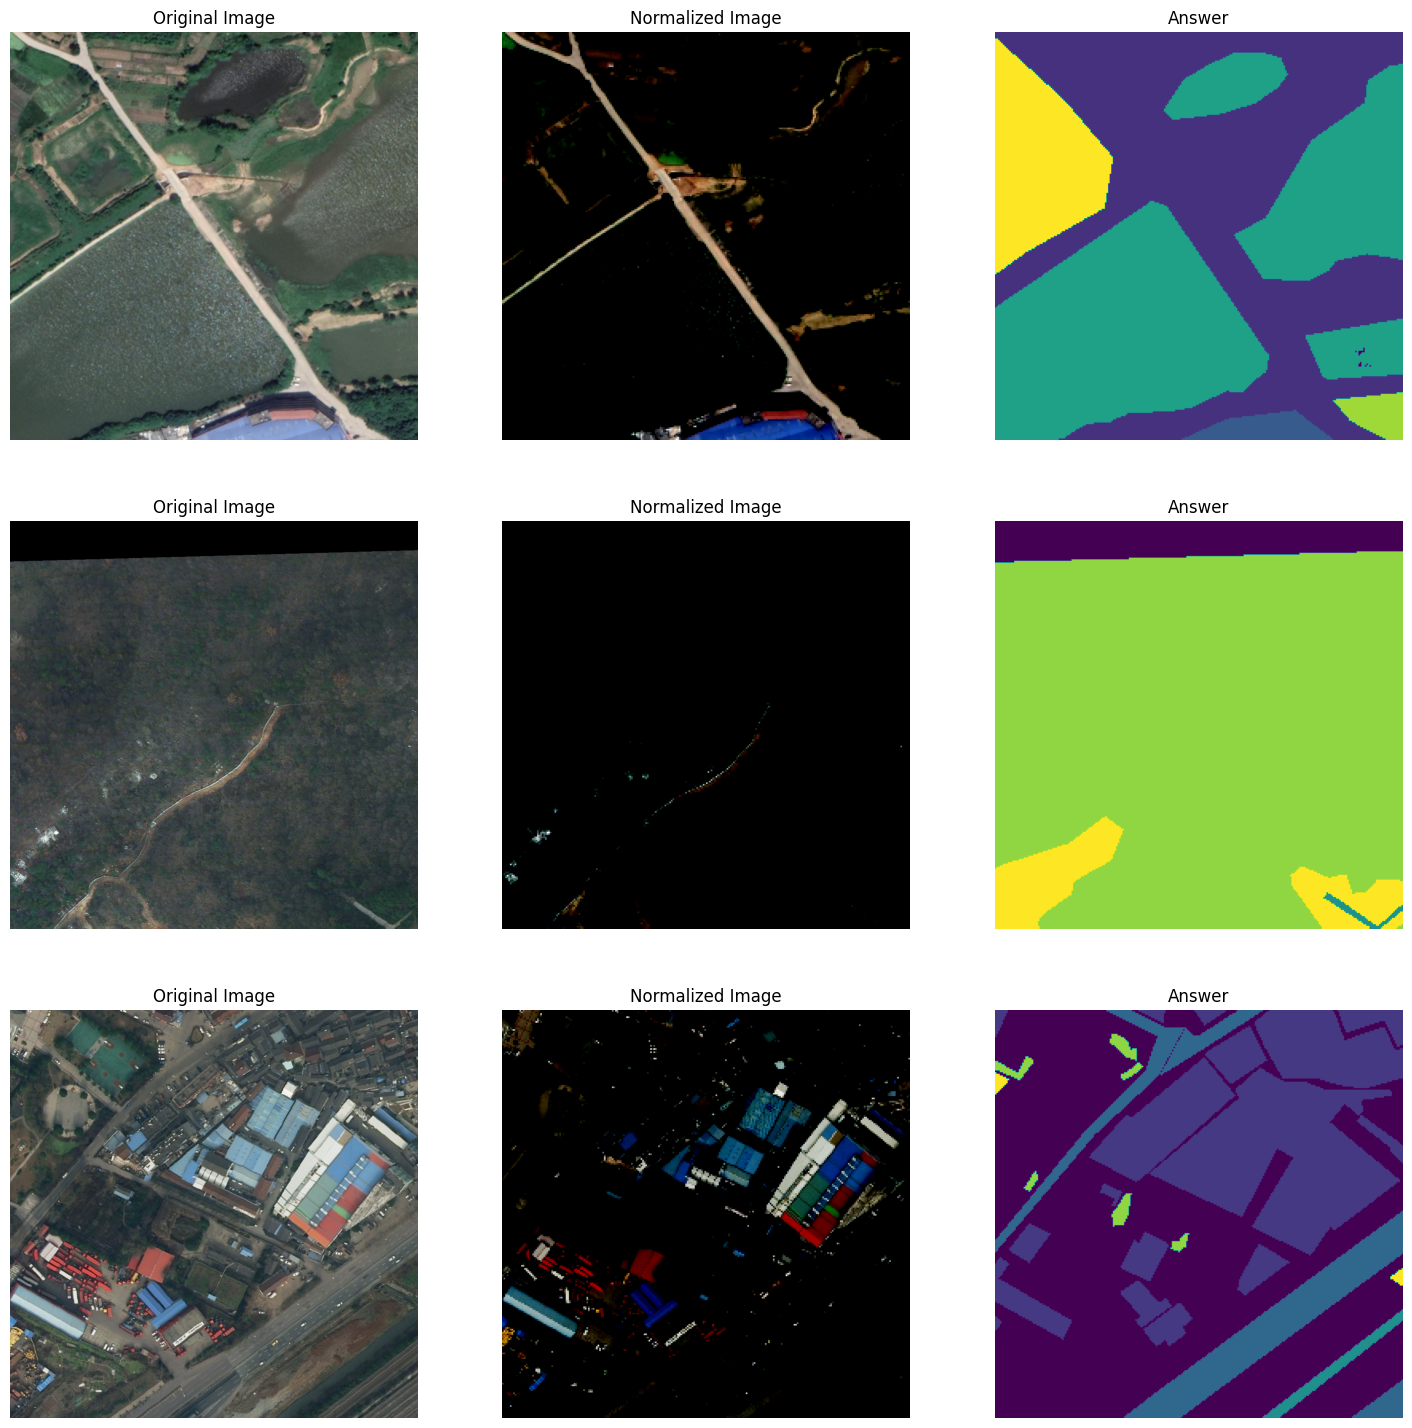

In [6]:
for orig_image,img,mask in train_dataloader:
    orig_img1 = np.transpose(orig_image[0,:,:,:],(0,1,2))
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])

    orig_img2 = np.transpose(orig_image[1,:,:,:],(0,1,2))
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])

    orig_img3 = np.transpose(orig_image[2,:,:,:],(0,1,2))
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))



    ax[0,0].set_title('Original Image')
    ax[0,1].set_title('Normalized Image')
    ax[0,2].set_title('Answer')
    ax[1,0].set_title('Original Image')
    ax[1,1].set_title('Normalized Image')
    ax[1,2].set_title('Answer')
    ax[2,0].set_title('Original Image')
    ax[2,1].set_title('Normalized Image')
    ax[2,2].set_title('Answer')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")


    ax[0][0].imshow(orig_img1)
    ax[0][1].imshow(img1)
    ax[0][2].imshow(mask1)

    ax[1][0].imshow(orig_img2)
    ax[1][1].imshow(img2)
    ax[1][2].imshow(mask2)

    ax[2][0].imshow(orig_img3)
    ax[2][1].imshow(img3)
    ax[2][2].imshow(mask3)
    break

In [7]:
class encoding_block(nn.Module):
    """
    UNetにおける基本的な部分。2回の畳み込みを行う。
    """
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)  

## UNetの定義

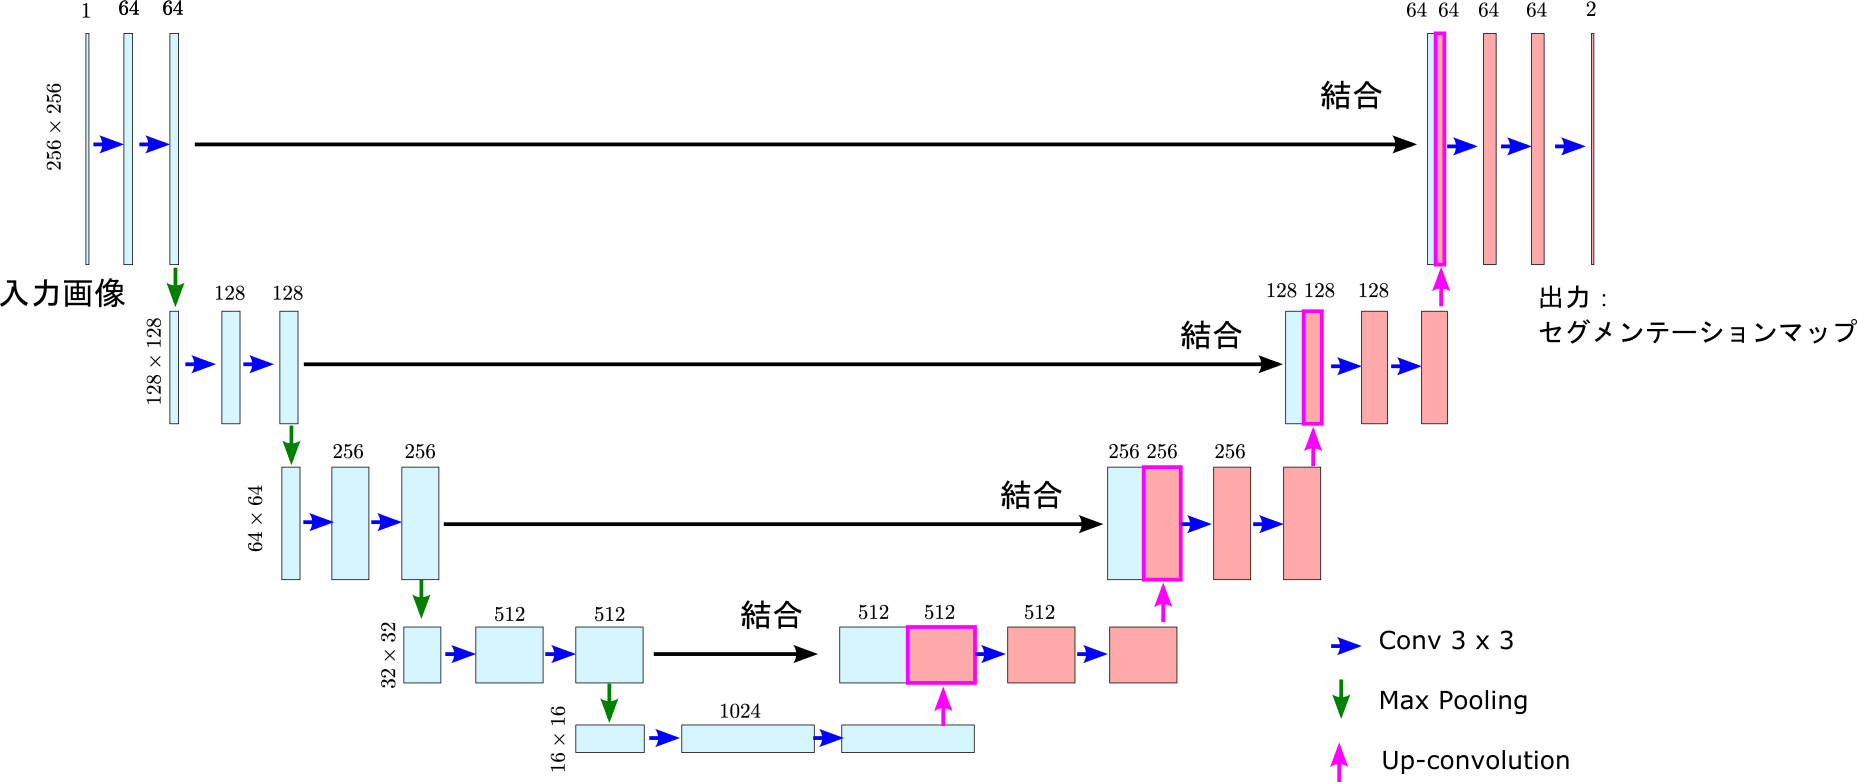

In [8]:
class UNet(nn.Module):
    """
    UNetのモデル定義
    デコーダー部分には、エンコーダーから出力されたfeature mapをconcatする。
    """
    def __init__(self,out_channels=23,features=[64, 128, 256, 512]):
        super(UNet,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
model = UNet().to(device)

In [12]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [15]:
num_epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir="logs/0715-UNet-2100/")

In [16]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_dataloader),total=len(train_dataloader))
    model.train()
    for batch_idx, (_,data, targets) in loop:
        data = data.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.long)

        # forwarding
        # withの中は計算高速化
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # 誤差逆伝播
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        
        loop.set_postfix(loss=loss.item())
        writer.add_scalar("Training loss", loss.item(), global_step=epoch*len(train_dataloader) + batch_idx)
    
    if (epoch+1) % 5 == 0:
        # eval
        eval_loss = 0
        model.eval()
        
        writer.add_scalar("Validation loss", loss.item(), global_step=epoch*len(train_dataloader) + batch_idx)
        for batch_idx, (_,data, targets) in enumerate(val_dataloader):
            data = data.to(device)
            targets = targets.to(device)
            targets = targets.type(torch.long)
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            eval_loss += loss.item()
        eval_loss /= len(val_dataloader)
        writer.add_scalar("Validation loss", eval_loss,global_step = epoch)

        model.train()

            

        torch.save(model.state_dict(), f"0715-UNet-2100/UNet_{epoch}epoch.pth")

100%|██████████| 316/316 [02:12<00:00,  2.38it/s, loss=0.882]


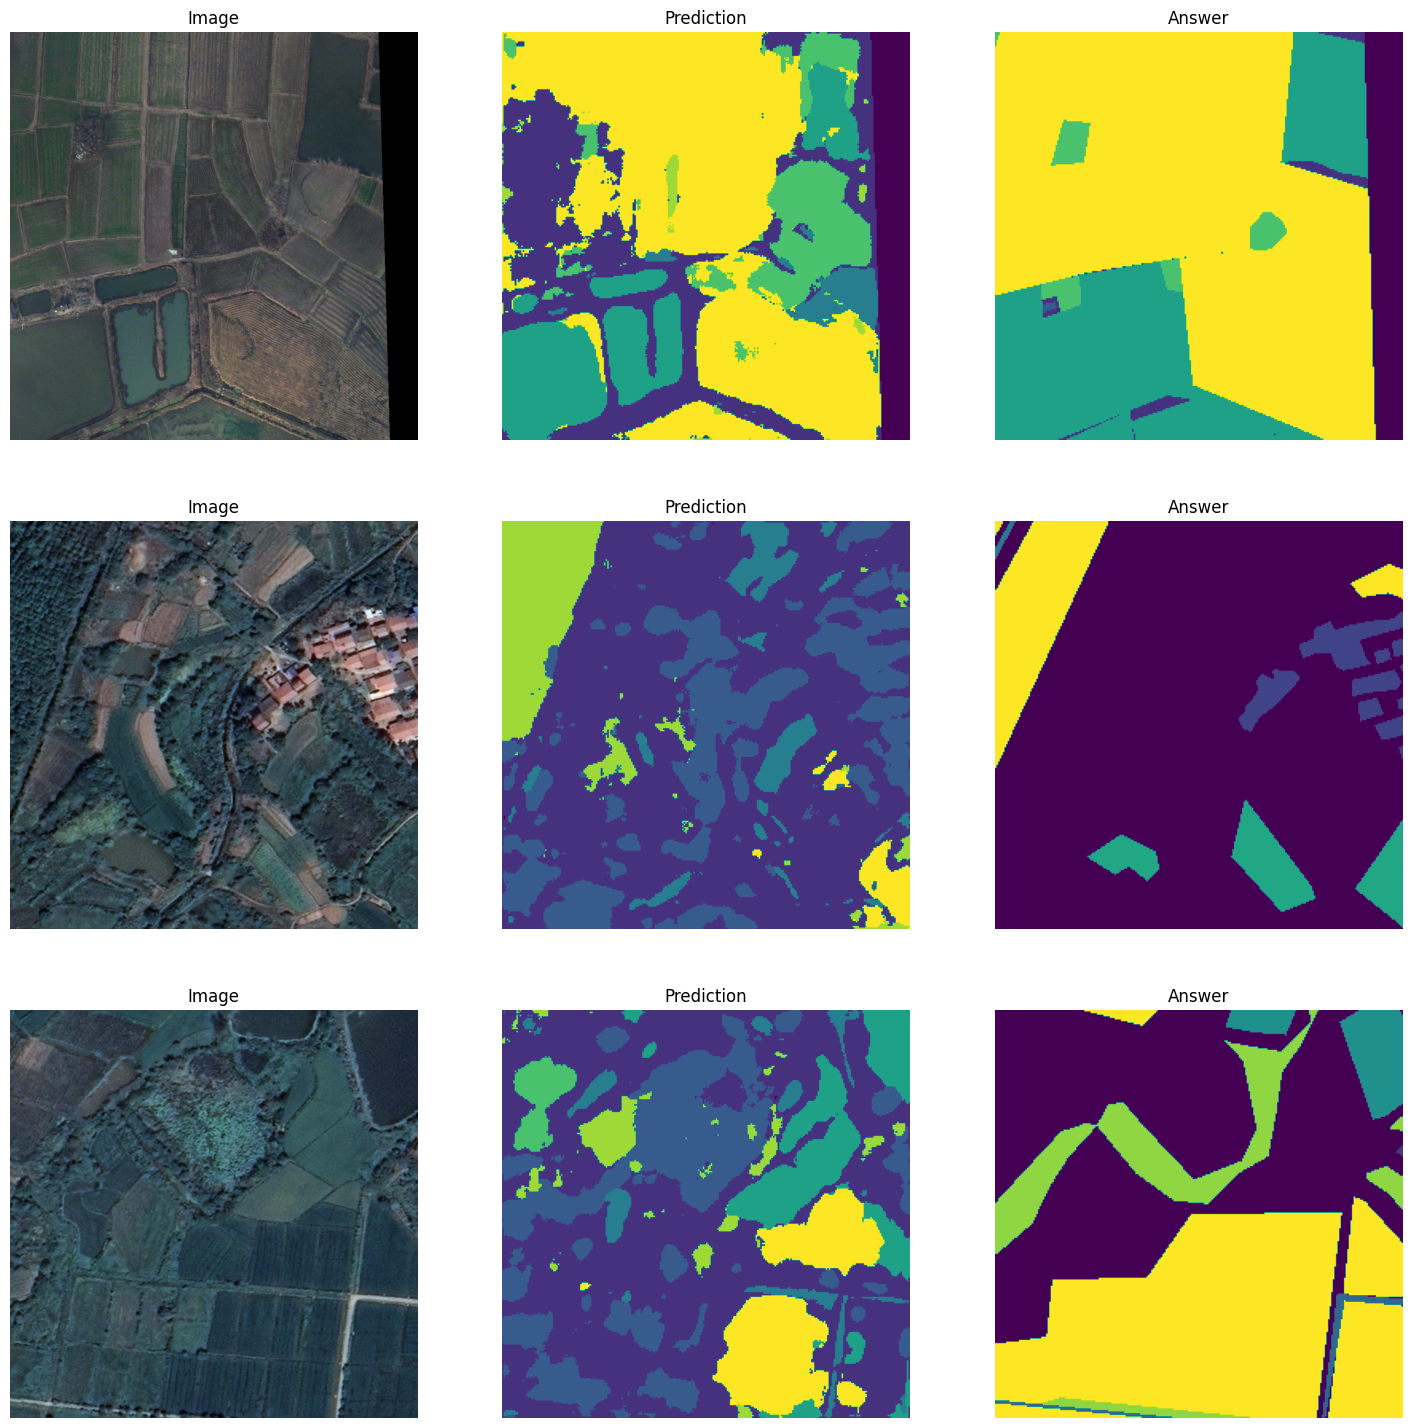

In [20]:
for orig_img,normalised,ans in val_dataloader:
    x = normalised.to(device)

    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(model(x),axis=1).to('cpu')


    img1 = np.transpose(np.array(orig_img[0,:,:,:].to('cpu')),(0,1,2))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(ans[0,:,:])
    img2 = np.transpose(np.array(orig_img[1,:,:,:].to('cpu')),(0,1,2))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(ans[1,:,:])
    img3 = np.transpose(np.array(orig_img[2,:,:,:].to('cpu')),(0,1,2))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(ans[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Answer')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Answer')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Answer')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break

In [ ]:
path_to_model = "0715-UNet-2100/UNet_20epoch.pth"

In [19]:
from torchmetrics.functional import jaccard_index
def compute_mIoU(path_to_model,dataloader,test_num):
    model = UNet().to(device)
    model.load_state_dict(torch.load(path_to_model))
    model.eval()

    ious = []
    for i in range(test_num):
        _, (data, targets) = next(enumerate(dataloader))
        data = data.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.long)
        with torch.no_grad():
            predictions = model(data)
            predictions = torch.argmax(predictions, dim=1)
            iou = jaccard_index(predictions, targets, num_classes = 8)
            ious.append(iou)
    print(f"mIoU: {sum(ious)/len(ious)}")


In [133]:
compute_mIoU(path_to_model,val_dataloader, 100)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 compute_mIoU(val_dataloader, 100)                                                            │
│   2                                                                                              │
│                                                                                                  │
│ in compute_mIoU:3                                                                                │
│                                                                                                  │
│    1 from torchmetrics.functional import jaccard_index                                           │
│    2 def compute_mIoU(dataloader,test_num):                                                      │
│ ❱  3 │   model = UNet().to(device)                                                               │
│    4 │   model.load_state_dict(torch.load("unetv2.pth"))                                         │
│    5 │   model.eval()                                                                            │
│    6                                                                                             │
│                                                                                                  │
│ /home/go/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1145 in to                │
│                                                                                                  │
│   1142 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│   1143 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│   1144 │   │                                                                                     │
│ ❱ 1145 │   │   return self._apply(convert)                                                       │
│   1146 │                                                                                         │
│   1147 │   def register_full_backward_pre_hook(                                                  │
│   1148 │   │   self,                                                                             │
│                                                                                                  │
│ /home/go/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:797 in _apply             │
│                                                                                                  │
│    794 │                                                                                         │
│    795 │   def _apply(self, fn):                                                                 │
│    796 │   │   for module in self.children():                                                    │
│ ❱  797 │   │   │   module._apply(fn)                                                             │
│    798 │   │                                                                                     │
│    799 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    800 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ /home/go/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:797 in _apply             │
│                                                                                                  │
│    794 │                                                                                         │
│    795 │   def _apply(self, fn):                                                                 │
│    796 │   │   for module in self.children():              

In [79]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [129]:
import torch, evaluate


metric = evaluate.load("mean_iou")
num_label = 8
IGNORE_INDEX = 0

# Category labels: background – 1, building – 2, road – 3, water – 4, barren – 5,forest – 6, agriculture – 7. And the no-data regions were assigned 0

id2label = {"1": "background", "2": "building", "3": "road", "4": "water", "5": "barren", "6": "forest", "7": "agriculture", "0": "no-data"}


def compute_metrics(eval_preds):
    with torch.no_grad():
        logits, masks = eval_preds
        logits_tensor = torch.from_numpy(logits)
        # resize the output logits to fit the size of the masks
        pred_labels = torch.nn.functional.interpolate(
            input=logits_tensor,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1).detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
            predictions=pred_labels,
            references=masks,
            num_labels=num_label,
            ignore_index=IGNORE_INDEX,
            # reduce_labels=feature_extractor.do_reduce_labels,
        )
        
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()
        
        metrics.update({
            f"accuracy_{id2label[idx]}": value for idx, value in enumerate(per_category_accuracy)
        })
        metrics.update({
            f"iou_{id2label[idx]}": value for idx, value in enumerate(per_category_iou)
        })
        
        return metrics

2023-07-15 21:12:10.296639: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 21:12:10.401773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 21:12:11.027552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [80]:
# torch.save(model.state_dict(), 'unetv2___.pth')

In [ ]:
def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = LyftUdacity(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    return train_dataloader,test_batch